## Import Packages

In [1]:
%matplotlib inline
import numpy as np
import collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(42)
torch.set_printoptions(edgeitems=2)

## Data Preperations

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../down/cifar-10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


## Training on GPU

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [4]:
import datetime as dt

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{}: Epoch {:0>2d}, Training loss: {}'.format(
                dt.datetime.now(), epoch, loss_train / len(train_loader)))

In [5]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-01-01 00:51:20.042461: Epoch 01, Training loss: 0.5477554391903482
2021-01-01 00:51:24.294476: Epoch 10, Training loss: 0.3274293661497201
2021-01-01 00:51:29.007981: Epoch 20, Training loss: 0.2898688439730626
2021-01-01 00:51:33.757601: Epoch 30, Training loss: 0.2668700110001169
2021-01-01 00:51:38.483847: Epoch 40, Training loss: 0.24748397015841903
2021-01-01 00:51:43.164377: Epoch 50, Training loss: 0.22887621995559923


## Model Baseline

In [7]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    
    for name, loader in [("train", train_loader), ("valid", val_loader)]:
        correct, total = 0, 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        accdict[name] = correct / total
        print("Accuracy {}: {:.2f}".format(name , correct / total))
    
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy valid: 0.88


In [8]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

## Model Width Design

In [9]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [10]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["width32"] = validate(model, train_loader, val_loader)

2021-01-01 00:51:43.930982: Epoch 01, Training loss: 0.5418027343264051
2021-01-01 00:51:48.066304: Epoch 10, Training loss: 0.3178378784922278
2021-01-01 00:51:52.639108: Epoch 20, Training loss: 0.2760268520967216
2021-01-01 00:51:57.237942: Epoch 30, Training loss: 0.2435669175283924
2021-01-01 00:52:01.834481: Epoch 40, Training loss: 0.21475106653324358
2021-01-01 00:52:06.419752: Epoch 50, Training loss: 0.18933348874947067

Accuracy train: 0.90
Accuracy valid: 0.88


In [11]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["width32"] = validate(model, train_loader, val_loader)

2021-01-01 00:52:07.156488: Epoch 01, Training loss: 0.538168589210814
2021-01-01 00:52:11.289672: Epoch 10, Training loss: 0.31550304876391294
2021-01-01 00:52:15.861703: Epoch 20, Training loss: 0.27211676718323097
2021-01-01 00:52:20.425598: Epoch 30, Training loss: 0.23581930311622135
2021-01-01 00:52:24.971630: Epoch 40, Training loss: 0.20697227305477592
2021-01-01 00:52:29.494837: Epoch 50, Training loss: 0.18345561571371782

Accuracy train: 0.90
Accuracy valid: 0.87


## Model Regularization

In [13]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{}: Epoch {:0>2d}, Training loss: {}'.format(
                dt.datetime.now(), epoch, loss_train / len(train_loader)))

In [14]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["l2-reg"] = validate(model, train_loader, val_loader)

2021-01-01 00:52:30.488760: Epoch 01, Training loss: 0.6102853569255513
2021-01-01 00:52:37.005492: Epoch 10, Training loss: 0.3544368408857637
2021-01-01 00:52:44.164040: Epoch 20, Training loss: 0.32075700505523924
2021-01-01 00:52:51.287472: Epoch 30, Training loss: 0.2985412694845989
2021-01-01 00:52:58.455070: Epoch 40, Training loss: 0.2798359503222119
2021-01-01 00:53:05.599610: Epoch 50, Training loss: 0.2636337302103164

Accuracy train: 0.89
Accuracy valid: 0.88


## Model Dropout

In [15]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
model.eval()
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2021-01-01 00:53:06.370521: Epoch 01, Training loss: 0.5619886961712199
2021-01-01 00:53:10.794485: Epoch 10, Training loss: 0.37240118974713005
2021-01-01 00:53:15.690811: Epoch 20, Training loss: 0.346705524879656
2021-01-01 00:53:20.606953: Epoch 30, Training loss: 0.33050534271510545
2021-01-01 00:53:25.579854: Epoch 40, Training loss: 0.31661834743372197
2021-01-01 00:53:30.518296: Epoch 50, Training loss: 0.29580261800319524

Accuracy train: 0.89
Accuracy valid: 0.88


## Model BatchNorm

In [17]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
model.eval()
all_acc_dict["bat-norm"] = validate(model, train_loader, val_loader)

2021-01-01 00:53:31.358906: Epoch 01, Training loss: 0.4683288301631903
2021-01-01 00:53:36.373655: Epoch 10, Training loss: 0.26752165225660723
2021-01-01 00:53:41.899595: Epoch 20, Training loss: 0.2042353250513411
2021-01-01 00:53:47.468525: Epoch 30, Training loss: 0.15340587026943828
2021-01-01 00:53:53.010266: Epoch 40, Training loss: 0.11011681565718287
2021-01-01 00:53:58.535022: Epoch 50, Training loss: 0.0760115959984102

Accuracy train: 0.96
Accuracy valid: 0.89


## Model NetDepth

In [19]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["netdepth"] = validate(model, train_loader, val_loader)

2021-01-01 00:53:59.384403: Epoch 01, Training loss: 0.682493119103134
2021-01-01 00:54:04.229325: Epoch 10, Training loss: 0.3406400009515179
2021-01-01 00:54:09.602175: Epoch 20, Training loss: 0.298995415970778
2021-01-01 00:54:14.987030: Epoch 30, Training loss: 0.2685222531769686
2021-01-01 00:54:20.386746: Epoch 40, Training loss: 0.23806965075860356
2021-01-01 00:54:25.772401: Epoch 50, Training loss: 0.20774338574735982

Accuracy train: 0.88
Accuracy valid: 0.87


## Model NetRes

In [21]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["net-res"] = validate(model, train_loader, val_loader)

2021-01-01 00:54:26.612262: Epoch 01, Training loss: 0.6631428303232618
2021-01-01 00:54:31.428123: Epoch 10, Training loss: 0.3376867757861022
2021-01-01 00:54:36.773742: Epoch 20, Training loss: 0.2913426273757485
2021-01-01 00:54:42.064590: Epoch 30, Training loss: 0.2552363721618227
2021-01-01 00:54:47.400679: Epoch 40, Training loss: 0.22443643824499884
2021-01-01 00:54:52.734404: Epoch 50, Training loss: 0.19762664516070846

Accuracy train: 0.89
Accuracy valid: 0.88


## Model ResBlock

In [23]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [24]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["res-deep"] = validate(model, train_loader, val_loader)

2021-01-01 00:55:01.513465: Epoch 01, Training loss: 1.4269282908955956
2021-01-01 00:56:17.368488: Epoch 10, Training loss: 0.29981718530320817
2021-01-01 00:57:41.869147: Epoch 20, Training loss: 0.24775966978187014
2021-01-01 00:59:06.319996: Epoch 30, Training loss: 0.18150420959113509
2021-01-01 01:00:30.566463: Epoch 40, Training loss: 0.15666025042960977
2021-01-01 01:01:55.036986: Epoch 50, Training loss: 0.10617878032955015

Accuracy train: 0.95
Accuracy valid: 0.87


## Model Comparisons

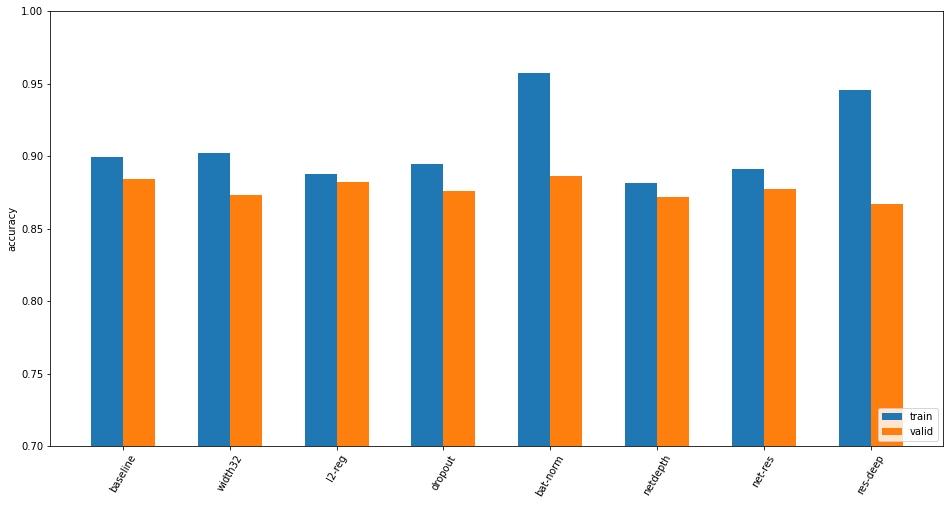

In [26]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['valid'] for k, v in all_acc_dict.items()]


width =0.3
plt.figure(figsize=(16, 8))
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='valid')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
# plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()